# Gentle Touch on Mr Bayes

### History
Bayes..., Laplace - who famously set probability that the Sun will rise tomorrow $P(X) = (r+1)/(n+2)$

## Bayesian statistics

The frequentist/Bayesian divide is a philosophical question **"what is probability?"**

- Freq: related to the event frequencies of repeated events

(50:50 chance coin/head, tails, huge number of tosses...)

- Bayes: related to our own certainty or uncertainty of events

(50:50 chance coin/head, tails, we have no information about prioritising one or the other belief...)

We analyze different thigs:

- Freq: variation of data in terms of fixed model parametes

- Bayes: variations of beliefs about parameters in terms of fixed observed data


... kind of opposite approach. Look what varies and what is fixed





$$ \underbrace{P(H \mid D)}_{posterior} = \frac{ \overbrace{P(D \mid H) }^{Likelihood}\, \overbrace{P(H)}^{Prior}}{\underbrace{P(D)}_{Model~ evidence}} $$

<img src="figures/bayes_drinking.png" width="50%">

### Bayes warm-up exercise

In a bag there are two balls, either both black oo (BB) or one black and one red o<font color="red">o</font> (BR).

I pick one ball randomly and it happened to be black.

1. What is the probability that the BB hypothesis is true?

2. What if we repeated the experiment 5 times in total and always picked the black ball? How would it change the probability that thee BB hypothesis is true?

$$P(BB | D) = \frac{P(BB) P(D|BB)}{P(D)}$$

and similarly

$$P(BR | D) = \frac{P(BR) P(D|BR)}{P(D)}$$

In [7]:
import numpy as np

# BB, BW
prior = np.array([0.5, 0.5]) # both hypothesis equally probable before we measure
lik = np.array([1., 0.5]) # prob to draw B from BB, prob to draw B from BW
h = prior*lik
Z = np.sum(h)
posterior = h/Z
posterior

array([0.66666667, 0.33333333])

In [8]:
# now we draw B 5x
prior = np.array([0.5, 0.5]) # both hypothesis equally probable before we measure
lik = np.array([1., 0.5**5]) # prob to draw 5x B from BB, prob to draw 5x B from BW
h = prior*lik
Z = np.sum(h)
posterior = h/Z
posterior

array([0.96969697, 0.03030303])

## Let's measure flux of a star

In [9]:
import matplotlib.pyplot as plt
from scipy import stats

In [10]:
# Generating some simple photon count data
np.random.seed(1)  # for repeatability

F_true = 1000  # true flux, say number of photons measured in 1 second
N = 50 # number of measurements
F = stats.poisson(F_true).rvs(N)  # N measurements of the flux
e = np.sqrt(F)  # errors on Poisson counts estimated via square root

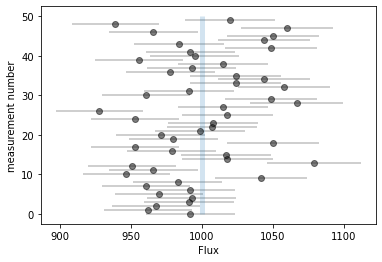

In [11]:
plt.errorbar(F, np.arange(N), xerr=e, fmt='ok', ecolor='gray', alpha=0.5)
plt.vlines([F_true], 0, N, linewidth=5, alpha=0.2)
plt.xlabel("Flux");plt.ylabel("measurement number");

**Frequentist approach** discussed last time, maximum likelihood $\mathcal{L}(D|F_{\rm true}) = \Pi_i^N P(D_i | F_{true})$, that analytically leads to minimising the least square error, which turns to be, in other words, weighted averaging

<img src="figures/likelihood.png" width="50%">

In [12]:
w = 1. / e ** 2

wavg = (w * F).sum() / w.sum()
werr = w.sum() ** -0.5
print("F_true = ", F_true)
print("F_estimated = ", wavg, "+/-", werr)

F_true =  1000
F_estimated =  997.679324193871 +/- 4.4669437520386825


### While the Bayesian...
The Bayesian approach is to compute our knowledge of the parameters:

$$ P(F_{\rm true}~|~D) $$

Note that this formulation of the problem is *fundamentally contrary* to the frequentist philosophy, which says that *probabilities have no meaning for model parameters* like $F_{\rm true}$. Nevertheless, within the Bayesian philosophy this is perfectly acceptable. 

To compute this result, apply Bayes' Theorem

$$ P(F_{\rm true}~|~D) = \frac{P(D~|~F_{\rm true})~P(F_{\rm true})}{P(D)} $$


- $P(F_{\rm true}~|~D)$: The **posterior**, or the probability of the model parameters given the data: this is the result we want to compute.
- $P(D~|~F_{\rm true})$: The **likelihood**, which is proportional to the $\mathcal{L}(D~|~F_{\rm true})$ in the frequentist approach, above.
- $P(F_{\rm true})$: The **model prior**, which encodes what we knew about the model prior to the application of the data $D$.
- $P(D)$: The **data probability**, which in practice amounts to simply a normalization term.


$$ \underbrace{P(\theta \mid D)}_{posterior} = \frac{ \overbrace{P(D \mid \theta) }^{Likelihood}\, \overbrace{P(\theta)}^{Prior}}{\underbrace{P(D)}_{Model~ evidence}} $$

If we set the prior $P(F_{\rm true}) \propto 1$ (a *flat prior* or a *non-informative*), we find

$$P(F_{\rm true}|D) \propto \mathcal{L}(D|F_{\rm true})$$

and the Bayesian probability is maximized at precisely the same value as the frequentist result!

So despite the philosophical differences, we see that (for this simple problem at least) the Bayesian and frequentist point estimates are equivalent.

But there are cases where the Freq and Bayes are not equal:

- prior (cosmological parameters from CMB, SNe...)
- handling of nuisance parameters
- interpretation iof unceratainty
- comparison of models


The posterior probability $P(F_{\rm true}~|~D)$ as a function of $F_{\rm true}$: this is the distribution reflecting our knowledge of the parameter $F_{\rm true}$.

But as the dimension of the model grows, this direct approach becomes increasingly intractable. For this reason, Bayesian calculations often depend on sampling methods such as [Markov Chain Monte Carlo (MCMC)](http://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo).

And the MCMC hammer in Python - that will sample the posterior probability for us - is called [emcee](https://emcee.readthedocs.io/en/stable/). For the purpose of today's lecture consider it a black-box that you provide data, priors and likelihoods (in the log form) and it returns the posterior *distribution* of probabilities (by calculating the integral for you in a smart way)

In [17]:
def log_prior(theta):
    return 1.  # flat prior

def log_likelihood(theta, F, e):
    return -0.5 * np.sum(np.log(2 * np.pi * e ** 2)
                         + (F - theta[0]) ** 2 / e ** 2)

def log_posterior(theta, F, e):
    return log_prior(theta) + log_likelihood(theta, F, e)

In [18]:
ndim = 1  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 2000  # number of MCMC steps to take

# we'll start at random locations between 0 and 2000
starting_guesses = 2000 * np.random.rand(nwalkers, ndim)

import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[F, e])
sampler.run_mcmc(starting_guesses, nsteps)

sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].ravel()  # discard burn-in points

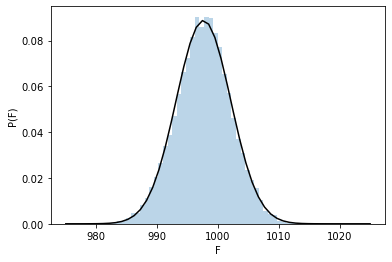

In [19]:
# plot a histogram of the sample
plt.hist(sample, bins=50, alpha=0.3, density=True)

# plot a best-fit Gaussian
F_fit = np.linspace(975, 1025)
pdf = stats.norm(np.mean(sample), np.std(sample)).pdf(F_fit)

plt.plot(F_fit, pdf, '-k')
plt.xlabel("F"); plt.ylabel("P(F)");

In [20]:
print("F_true = ",F_true)
print("F_estimated  = ", np.mean(sample), "+/- ", np.std(sample))

F_true =  1000
F_estimated  =  997.6108844366869 +/-  4.4912001221610875


## Nuisance parameters
A nuisance parameter is any quantity whose value is not relevant to the goal of an analysis, but is nevertheless required to determine the result.

## The Bayesian Billiard Game

- the first ball divides the table
- additional rolls give points to A or B
- first person who gets 6 points wins

<img src="figures/Bayes_game_board.png">

<img src="figures/black_board.png">

Question: In a certain game Alice has 5 points and Bob has 3 points. What are the odds that Bob will win?

Frequentist Approach:

$\hat{p} =5/8$

$P(B)=(1−\hat{p})^3$

In [21]:
p_hat = 5. / 8.
freq_prob = (1 - p_hat) ** 3
print("Frequentist Probability of Bob Winning: %.2f"%freq_prob)
print("Odds %0.0f to 1" % ((1. - freq_prob)/ freq_prob))

Frequentist Probability of Bob Winning: 0.05
Odds 18 to 1


### Bayesian approach

- $B$ = Bob Wins
- $D$ = observed data, i.e. $D = (n_A, n_B) = (5, 3)$
- $p$ = unknown probability that a ball lands on Alice's side during the current game

We want to compute $P(B~|~D)$; that is, the probability that Bob wins given our observation that Alice currently has five points to Bob's three.

The general Bayesian method of treating nuisance parameters is *marginalization*, or integrating the joint probability over the entire range of the nuisance parameter. In this case, that means that we will first calculate the joint distribution
$$
P(B,p~|~D)
$$
and then marginalize over $p$ using the following identity:
$$
P(B~|~D) \equiv \int_{-\infty}^\infty P(B,p~|~D) {\mathrm d}p
$$
This identity follows from the definition of conditional probability, and the law of total probability: that is, it is a fundamental consequence of probability axioms and will always be true. Even a frequentist would recognize this; they would simply disagree with our interpretation of $P(p)$ as being a measure of uncertainty of our own knowledge.

We'll start by applying the following definition of [conditional probability](http://en.wikipedia.org/wiki/Conditional_probability#Definition) to expand the term $P(B,p~|~D)$:

$$
P(B~|~D) = \int P(B~|~p, D) P(p~|~D) dp
$$

Next we use [Bayes' rule](http://en.wikipedia.org/wiki/Bayes%27_theorem) to rewrite $P(p~|~D)$:

$$
P(B~|~D) = \int P(B~|~p, D) \frac{P(D~|~p)P(p)}{P(D)} dp
$$

Finally, using the same probability identity we started with, we can expand $P(D)$ in the denominator to find:

$$
P(B~|~D) = \frac{\int P(B~|~p,D) P(D~|~p) P(p) dp}{\int P(D~|~p)P(p) dp}
$$

Now the desired probability is expressed in terms of three quantities that we can compute. Let's look at each of these in turn:

- $P(B~|~p,D)$: This term is exactly the frequentist likelihood we used above. In words: given a marker placement $p$ and the fact that Alice has won 5 times and Bob 3 times, what is the probability that Bob will go on to six wins?  Bob needs three wins in a row, i.e. $P(B~|~p,D) = (1 - p) ^ 3$.
- $P(D~|~p)$: this is another easy-to-compute term. In words: given a probability $p$, what is the likelihood of exactly 5 positive outcomes out of eight trials? The answer comes from the well-known [Binomial distribution](http://en.wikipedia.org/wiki/Binomial_distribution): in this case $P(D~|~p) \propto p^5 (1-p)^3$
- $P(p)$: this is our prior on the probability $p$. By the problem definition, we can assume that $p$ is evenly drawn between 0 and 1.  That is, $P(p) \propto 1$, and the integrals range from 0 to 1.

Putting this all together, canceling some terms, and simplifying a bit, we find
$$
P(B~|~D) = \frac{\int_0^1 (1 - p)^6 p^5 dp}{\int_0^1 (1 - p)^3 p^5 dp}
$$
where both integrals are evaluated from 0 to 1.

These integrals might look a bit difficult, until we notice that they are special cases of the [Beta Function](http://en.wikipedia.org/wiki/Beta_function):
$$
\beta(n, m) = \int_0^1 (1 - p)^{n - 1} p^{m - 1}
$$
The Beta function can be further expressed in terms of gamma functions (i.e. factorials), but for simplicity we'll compute them directly using Scipy's beta function implementation:

In [22]:
from scipy.special import beta
bayes_prob = beta(6 + 1, 5 + 1) / beta(3 + 1, 5 + 1)

print("P(B|D) = {0:.2f}".format(bayes_prob))

print("Bayesian odds %.0f to 1" % ((1. - bayes_prob) / bayes_prob))


P(B|D) = 0.09
Bayesian odds 10 to 1


### 0.05 vs 0.09, so who is right?

In [23]:
np.random.seed(0)

# play 100000 games with randomly-drawn p, between 0 and 1
p = np.random.random(100000)

# each game needs at most 11 rolls for one player to reach 6 wins
rolls = np.random.random((11, len(p)))

# count the cumulative wins for Alice and Bob at each roll
Alice_count = np.cumsum(rolls < p, 0)
Bob_count = np.cumsum(rolls >= p, 0)

# sanity check: total number of wins should equal number of rolls
total_wins = Alice_count + Bob_count
assert np.all(total_wins.T == np.arange(1, 12))
print("(Sanity check passed)")

# determine number of games which meet our criterion of (A wins, B wins)=(5, 3)
# this means Bob's win count at eight rolls must equal 3
good_games = Bob_count[7] == 3
print("Number of suitable games: ", good_games.sum())

# truncate our results to consider only these games
Alice_count = Alice_count[:, good_games]
Bob_count = Bob_count[:, good_games]

# determine which of these games Bob won.
# to win, he must reach six wins after 11 rolls.
bob_won = np.sum(Bob_count[10] == 6)
print("Number of these games Bob won: ", bob_won.sum())

# compute the probability
mc_prob = bob_won.sum() * 1. / good_games.sum()
print("Monte Carlo Probability of Bob winning: %.2f" % mc_prob)
print("MC Odds against Bob winning: %.0f to 1" % ((1. - mc_prob) / mc_prob))

(Sanity check passed)
Number of suitable games:  11068
Number of these games Bob won:  979
Monte Carlo Probability of Bob winning: 0.09
MC Odds against Bob winning: 10 to 1


<img src="figures/game_freq.png" width="50%">
<img src="figures/game_bayes.png" width="50%">

### Earthquake exercise

<img src="figures/spitak.jpg" width="50%">

There were 20 earthquakes observed in last 20.000 years. What is the probability of having an earthquake within next 50 years?

Calculate it first using the frequentist approach, then the Bayesian approach, and compare.

You may use your favourite $R$ if you like.

Assume, the earthquakes follow the Poission distribution

$$P(x, \lambda) =  \frac{\lambda^x \exp(-\lambda)}{x!}$$

where $\lambda$ is the earthquake rate in a unit time period.

## Uncertainties: Confidence interval vs Credibility interval

What does it mean $\theta = 999 \pm 4$ ?

- Freq: If the experiment is repeated many times, in 95% of these cases the computed confidence interval will contain the true value $\theta$


- Bayes: Given our observed data, there is a 95% probability that the value of $\theta$ lies within the credible region

Notice again what varies and what is fixed!

<img src="figures/confidence_credibility.png" width="50%">

But in principle, we may have chosen (find) this one by 5% chance...

<img src="figures/confidence_credibility_fail.png" width="50%">

A frequentist 95% confidence interval is **not** 95% likely to contain the true value!

This is a very common mistake, and it's a Bayesian interpretation of a frequenctist coonstruct.

## Bayesian model selection
### The difference between model fitting and model selection

*Model fitting* assumes the particular model is true, and tuning the model so it provides the best possible fit to the data of the given model.

*Model selection* asks the question of whether the assumptions of the model are compatible with the data.

Example, linear model $M_1$ vs. quadratic model $M_2$

$$
y_{M_1}(x;\theta) = \theta_0 + \theta_1 x
$$

$$
y_{M_2}(x;\theta) = \theta_0 + \theta_1 x + \theta_2 x^2\\
$$



In [35]:
def generate_data(N=20, rseed=1):
    rng = np.random.RandomState(rseed)
    x = rng.rand(N)
    sigma_y = 0.1 * np.ones(N)
    
    # linear model with noise
    y = x - 0.2 + sigma_y * rng.randn(N)
    return np.vstack([x, y, sigma_y]).round(2)

data = generate_data()
x, y, sigma_y = data

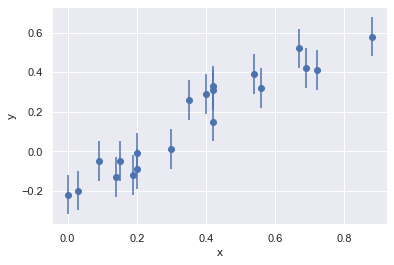

In [36]:
plt.errorbar(x, y, sigma_y, fmt="o")
plt.xlabel('x')
plt.ylabel('y');

In [37]:
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    return sum(t * x ** n for (n, t) in enumerate(theta))

In [38]:
# function which computes the log-likelihood for the models

from scipy import stats

def logL(theta, model=polynomial_fit, data=data):
    """Gaussian log-likelihood of the model at theta"""
    x, y, sigma_y = data
    y_fit = model(theta, x)
    return sum(stats.norm.logpdf(*args)
               for args in zip(y, y_fit, sigma_y))

In [39]:
from scipy import optimize

def best_theta(degree, model=polynomial_fit, data=data):
    theta_0 = (degree + 1) * [0]
    neg_logL = lambda theta: -logL(theta, model, data)
    return optimize.fmin_bfgs(neg_logL, theta_0, disp=False)

theta1 = best_theta(1)
theta2 = best_theta(2)

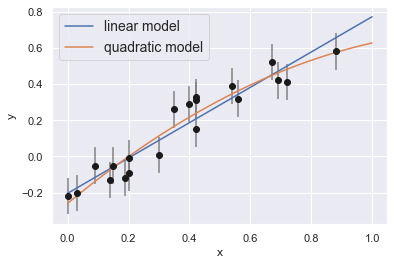

In [40]:
xfit = np.linspace(0, 1, 1000)
plt.errorbar(x, y, sigma_y, fmt='ok', ecolor='gray')
plt.plot(xfit, polynomial_fit(theta1, xfit), label='linear model')
plt.plot(xfit, polynomial_fit(theta2, xfit), label='quadratic model')
plt.legend(loc='best', fontsize=14)
plt.xlabel('x'); plt.ylabel('y');

Naive Approach: Comparing Maximum Likelihoods

In [41]:
print("linear model:    logL =", logL(best_theta(1)))
print("quadratic model: logL =", logL(best_theta(2)))

linear model:    logL = 22.01086700661255
quadratic model: logL = 22.94151358650395


The quadratic model yields a higher log-likelihood, but this **does not** necessarily mean it is the better model!

The quadratic model has more degrees of freedom than the linear model, and thus will **always** give an equal or larger maximum likelihood, regardless of the data!

We have talked over-fitting in one of the previous lectures...

There exist some treatments, i.e. the **Akaike Information Criterion** that corrects the likelihood for the degrees of freedom...

### Reminder of Bayesian vs Frequentist philosophies

Frequentists consider **probabilities as frequencies**: that is, a probability is only meaningful in the context of repeated experiments (even if those repetitions are hypothetical).

- *observed data* are considered to be random variables: if you make the observations again under similar circumstances, the data may be different, and the details depend on the generating distribution.
- *model parameters* (those things that help define the generating distribution) are considered fixed: they aren't subject to a probability distribution; they just *are*.

Bayesians consider **probabilities as degrees-of-belief**: that is, a probability is a way of quantifying our certainty about a particular statement.

- *observed data* are not directly considered as random variables; they just *are*.
- *model parameters* are uncertain quantities and thus subject to probabilistic description.

In the model fitting context:

- frequentists look at the *likelihood*: $P(D~|~\theta, M)$
- Bayesians look at the *posterior*: $P(\theta~|~D, M)$

### Model Selection: Frequentists Approach

We have discussed this already, recall $\chi^2$ distribution, the difference of the $\chi^2$ and its p-value...

### Model Selection: Bayesian Approach

First, using Mr Bayes:

$$
P(M~|~D) = P(D~|~M)\frac{P(M)}{P(D)}
$$

Using the definition of conditional probability, the first term can be expressed as an integral over the parameter space of the likelihood:

$$
P(D~|~M) = \int_\Omega P(D~|~\theta, M) P(\theta~|~M) d\theta
$$

The remaining terms are priors, the most problematic of which is $P(D)$ – the prior probability of seeing your data *without reference to any model*.
I'm not sure that $P(D)$ could ever be actually computed in the real world, but fortunately it can be canceled by computing the *odds ratio* between two alternative models:

$$
O_{21} \equiv \frac{P(M_2~|~D)}{P(M_1~|~D)} = \frac{P(D~|~M_2)}{P(D~|~M_1)}\frac{P(M_2)}{P(M_1)}
$$

We now have a means of comparing two models via computable quantities: an integral over the likelihood, and a prior odds for each model.
Often the ratio of prior odds is assumed to be $P(M_1)/P(M_2) \sim 1$, leaving only the well-defined (but often computationally intensive) integral over likelihood for each model.

The ratio $P(D~|~M_2) / P(D~|~M_1)$ is the *Bayes factor*

Notice, that for model selection, the frequentists are also working with the quantity $P(D~|~M)$. But unlike Bayesians, they *cannot* express this as an integral over parameter space, because the notion of a probability distribution over model parameters does not make sense in the frequentist context. The parameter space is only one ground true paramater vector.

Use an MCMC to draw samples (emcee) from the posterior in order to solve the model fitting problem. The emcee package requires to first define functions which compute the prior, likelihood, and posterior under each model:

In [42]:
def log_prior(theta):
    # size of theta determines the model.
    # flat prior over a large range
    if np.any(abs(theta) > 100):
        return -np.inf  # log(0)
    else:
        return 200 ** -len(theta)

def log_likelihood(theta, data=data):
    x, y, sigma_y = data
    yM = polynomial_fit(theta, x)
    return -0.5 * np.sum(np.log(2 * np.pi * sigma_y ** 2)
                         + (y - yM) ** 2 / sigma_y ** 2)

def log_posterior(theta, data=data):
    theta = np.asarray(theta)
    return log_prior(theta) + log_likelihood(theta, data)

In [43]:
# we draw samples from the posterior using MCMC

import emcee

def compute_mcmc(degree, data=data,
                   log_posterior=log_posterior,
                   nwalkers=50, nburn=1000, nsteps=2000):
    ndim = degree + 1  # this determines the model
    rng = np.random.RandomState(0)
    starting_guesses = rng.randn(nwalkers, ndim)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[data])
    sampler.run_mcmc(starting_guesses, nsteps)
    trace = sampler.chain[:, nburn:, :].reshape(-1, ndim)
    return trace

trace_2D = compute_mcmc(1)
trace_3D = compute_mcmc(2)

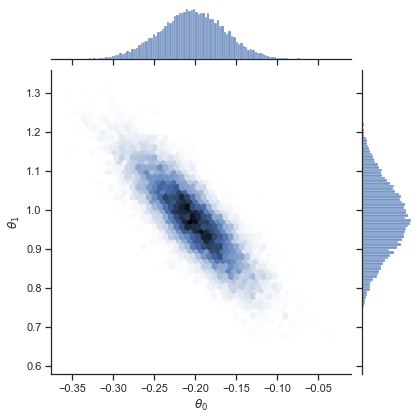

In [44]:
import seaborn as sns; # sns.set()
import pandas as pd
columns = [r'$\theta_{0}$'.format(i) for i in range(3)]
df_2D = pd.DataFrame(trace_2D, columns=columns[:2])

with sns.axes_style('ticks'):
    jointplot = sns.jointplot(x=r'$\theta_0$', y=r'$\theta_1$',
                              data=df_2D, kind="hex");

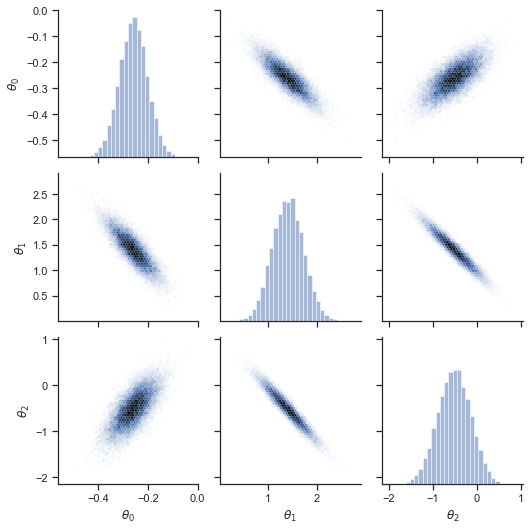

In [45]:
df_3D = pd.DataFrame(trace_3D, columns=columns[:3])

# get the colormap from the joint plot above
cmap = jointplot.ax_joint.collections[0].get_cmap()

with sns.axes_style('ticks'):
    grid = sns.PairGrid(df_3D)
    grid.map_diag(plt.hist, bins=30, alpha=0.5)
    grid.map_offdiag(plt.hexbin, gridsize=50, linewidths=0, cmap=cmap)

These samples give us a good idea of what the posterior for each model looks like, but we still must integrate this posterior to find the Bayes factor.

In [46]:
from scipy import integrate

def integrate_posterior_2D(log_posterior, xlim, ylim, data=data):
    func = lambda theta1, theta0: np.exp(log_posterior([theta0, theta1], data))
    return integrate.dblquad(func, xlim[0], xlim[1],
                             lambda x: ylim[0], lambda x: ylim[1])

def integrate_posterior_3D(log_posterior, xlim, ylim, zlim, data=data):
    func = lambda theta2, theta1, theta0: np.exp(log_posterior([theta0, theta1, theta2], data))
    return integrate.tplquad(func, xlim[0], xlim[1],
                             lambda x: ylim[0], lambda x: ylim[1],
                             lambda x, y: zlim[0], lambda x, y: zlim[1])

In [47]:
xlim, ylim = zip(trace_2D.min(0), trace_2D.max(0))
Z1, err_Z1 = integrate_posterior_2D(log_posterior, xlim, ylim)
print("Z1 =", Z1, "+/-", err_Z1)

Z1 = 46944203.62796968 +/- 2.888255804144592


In [48]:
xlim, ylim, zlim = zip(trace_3D.min(0), trace_3D.max(0))
Z2, err_Z2 = integrate_posterior_3D(log_posterior, xlim, ylim, zlim)
print("Z2 =", Z2, "+/-", err_Z2)

Z2 = 111122358.91704482 +/- 13.698354807682335


In [49]:
print("Bayes factor:", Z2 / Z1)

Bayes factor: 2.367115646431743


In [50]:
print('Bayesian "p-value":', Z1 / (Z1 + Z2))

Bayesian "p-value": 0.29699009627416184


The posterior probability in favor of the linear model is about 30%, which is not low enough to support rejecting the simpler model.

Keep in mind, this is not a true p-value in the meaning of the p-value definition...

### Solution to the Earthquake exercise

In [71]:
from scipy.stats import poisson

In [72]:
N = 100
lam = np.linspace(1,100,N)
prior = np.ones_like(lam)/N
np.sum(prior)

0.9999999999999999

In [96]:
# Likelihood P( data | model ) :
# P(x, lambda) = lambda^x exp(-lambda) / x!
lik = poisson.pmf(20,lam)

In [74]:
h = prior * lik
Z  = np.sum(h) # norm. factor
post = h/Z # posterior

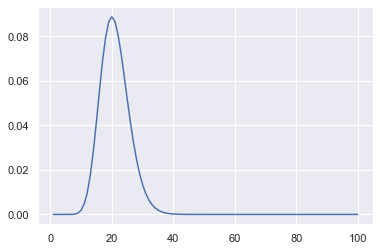

In [75]:
plt.plot(lam, post)

As an improvement you can use log-uniform proir, which is equivalent to changing from $x$ to $1/x$

In [76]:
# prior = np.ones_like(lam)/lam
# prior = prior/np.sum(prior)

In [94]:
# freq, lambda = 20 in 20 000 years, fixed
lambda_fixed = 20
freq_prob = 1.-poisson.pmf(0,50/20000*lambda_fixed)
freq_prob

0.048770575499285984

Bayes: integrate over all possible lambda's to get the mean (expected) value, $$\mathbb E[x] = \int x p(x) dx$$

In [95]:
prob = 1.- poisson.pmf(0, 50/20000*lam) # for all possible lambda's
bayes_prob = np.sum(post*prob)
bayes_prob

0.05108351192968037

### Redo the Bayes' billiard game numerically

In [97]:
from scipy.stats import binom

In [139]:
N = 100
p = np.linspace(0,1,N)
step = p[1]-p[0]
prior = np.ones_like(p)/N
np.sum(prior), step

(0.9999999999999999, 0.010101010101010102)

In [140]:
n, k = 8, 5
lik = binom.pmf(k, n, p)

In [141]:
h = prior * lik
Z  = step*np.sum(h) # norm. factor
post = h/Z # posterior
step*np.sum(post)

0.9999999999999999

In [142]:
prob = binom.pmf(3,3,1-p)
bayes_prob = step*np.sum(post*prob)
bayes_prob

0.09090908693428823